In [1]:
import random
import numpy as np
import tensorflow as tf
import mlflow.keras
import pandas as pd

from ml_investing_wne import config
from ml_investing_wne.utils import get_logger
from ml_investing_wne.experiment_factory import create_asset, experiment_factory

random.seed(config.seed)
np.random.seed(config.seed)
tf.random.set_seed(config.seed)

build_model for keras_tuner_CNN_LSTM not implemented!


In [2]:
print(config.currency)
print(config.freq) 
asset = create_asset()
experiment= experiment_factory(asset).get_experiment()

ETHUSDT
1440min


In [3]:
print(config.fixed_barrier)
print(config.RUN_SUBTYPE)

0.025
range_bar


In [4]:
# change all column types to numeric
experiment.df = experiment.df.apply(pd.to_numeric, errors='ignore')
experiment.df.dtypes

open             float64
high             float64
low              float64
close            float64
volume           float64
y_pred           float64
EMA_5            float64
VAR_5            float64
EMA_10           float64
VAR_10           float64
EMA_15           float64
VAR_15           float64
EMA_20           float64
VAR_20           float64
EMA_50           float64
VAR_50           float64
MACD_12_26_9     float64
MACDh_12_26_9    float64
MACDs_12_26_9    float64
RSI_14           float64
RSI_10           float64
RSI_6            float64
STOCHk_14_3_3    float64
STOCHd_14_3_3    float64
WILLR_14         float64
BBL_5_2.0        float64
BBM_5_2.0        float64
BBU_5_2.0        float64
BBB_5_2.0        float64
BBP_5_2.0        float64
roc_1            float64
CMF_20           float64
MFI_14           float64
hour_sin         float64
hour_cos         float64
weekday_sin      float64
weekday_cos      float64
dtype: object

In [5]:
experiment.df.head(2)

,open,high,low,close,volume,y_pred,EMA_5,VAR_5,EMA_10,VAR_10,...,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,roc_1,CMF_20,MFI_14,hour_sin,hour_cos,weekday_sin,weekday_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-02 02:39:00,865.02,867.65,849.0,852.53,1855.45604,1.014510,866.759675,178.79567,866.180627,108.88224,...,895.447577,5.489113,0.102878,-0.014439,0.120272,42.802232,0.519584,0.854419,0.866025,0.5
2018-01-02 02:51:00,852.53,865.00,840.0,864.90,2825.66757,0.984172,866.139784,181.18858,865.947785,116.15549,...,893.553108,5.538776,0.405021,0.014510,0.224086,55.837665,0.519584,0.854419,0.866025,0.5


In [6]:
experiment.df.to_csv('ETHUSDT_rangebar001.csv')

In [7]:
# experiment.df.drop(columns=['to_keep'],inplace=True)

In [25]:
train = experiment.df[experiment.df.index < config.train_end]
val = experiment.df[(experiment.df.index >= config.train_end) & (experiment.df.index < config.val_end)]
test = experiment.df[experiment.df.index >= config.val_end]
train_val = experiment.df[experiment.df.index < config.val_end]
train_test = pd.concat([train, test])

In [26]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [27]:
train_indices = np.where(train.index < config.train_end, -1, 0)
val_indices = np.where(val.index < config.val_end, 0, 1)
test_indices = np.where(test.index >= config.val_end, 0, 1)

In [28]:
split_indices = np.append(train_indices, val_indices)
# split_indices = np.append(train_indices, test_indices)
print(split_indices)
ps = PredefinedSplit(test_fold=split_indices)

[-1 -1 -1 ...  0  0  0]


In [29]:
for i, (train_index, test_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[    0     1     2 ... 18560 18561 18562]
  Test:  index=[18563 18564 18565 ... 20980 20981 20982]


In [22]:
split_indices.shape

(28276,)

In [81]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)


In [82]:
train.shape[0] + val.shape[0]

20983

In [12]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [90]:


def xgboost_tuning(train, val):
    # Split the data into training and validation sets
    y_train = train['y_pred']
    X_train = train.drop(['y_pred'], axis=1)
    y_val = val['y_pred']
    X_val = val.drop(['y_pred'], axis=1)
    
    # Define the hyperparameters to tune
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2]
    }

    # Create a GridSearchCV object
    cv = GridSearchCV(xgb.XGBClassifier(), param_grid, scoring='accuracy', cv=ps, n_jobs=-1)

    # Fit the model to the training data
    cv.fit(X_train, y_train)

    # Evaluate the model on the validation data
    val_pred = cv.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)

    # Print the best parameters and validation accuracy
    print(cv.best_params_)
    print(val_accuracy)
   

In [9]:
# xgboost_tuning(train, val)

In [35]:
y_train_val = train_val['y_pred']
X_train_val = train_val.drop(['y_pred'], axis=1)
y_train = train['y_pred']
X_train = train.drop(['y_pred'], axis=1)
y_val = val['y_pred']
X_val = val.drop(['y_pred'], axis=1)
# Define the hyperparameters to tune
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.2],
    'reg_lambda': [0.0, 0.1, 0.2]
}
# Create a RandomizedSearchCV object
cv = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions, scoring='accuracy', n_iter=10, cv=ps, n_jobs=-1, refit=False)
# Fit the model to the training data
cv.fit(X_train_val, y_train_val)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0.0, 0.1, 0.2],
                                        'reg_lambda': [0.0, 0.1, 0.2],
                                        'subsample': [0.5, 0.7, 1.0]},
                   refit=False, scoring='accuracy')

In [38]:
best_params = cv.best_params_
best_params


{'subsample': 1.0,
 'reg_lambda': 0.0,
 'reg_alpha': 0.2,
 'n_estimators': 300,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 0.2,
 'colsample_bytree': 0.9}

In [44]:
xg_clf = xgb.XGBClassifier(objective='binary:logistic', **best_params)
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
cv.cv_results_

{'mean_fit_time': array([20.32732797,  9.95065188, 11.92745209, 15.69356608,  7.14125681,
        10.64880109, 20.45348573,  7.196805  ,  5.75219107, 10.76335073]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.01366091, 0.00518298, 0.00669503, 0.00946999, 0.00586128,
        0.00643206, 0.01056623, 0.00521302, 0.00447106, 0.00776815]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_subsample': masked_array(data=[0.5, 1.0, 0.7, 0.7, 0.5, 0.5, 1.0, 0.7, 0.7, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.1, 0.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data

In [52]:
def get_top_n_hyperparameters(cv_results, n):
    results = pd.DataFrame(cv_results)
    results = results.sort_values(by='rank_test_score')
    return results[:n]

In [53]:
get_top_n_hyperparameters(cv.cv_results_, 5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
1,9.950652,0.0,0.005183,0.0,1.0,0.0,0.2,300,3,0.01,0.2,0.9,"{'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alp...",0.548347,0.548347,0.0,1
0,20.327328,0.0,0.013661,0.0,0.5,0.0,0.0,300,7,0.05,0.1,1.0,"{'subsample': 0.5, 'reg_lambda': 0.0, 'reg_alp...",0.539669,0.539669,0.0,2
9,10.763351,0.0,0.007768,0.0,0.5,0.0,0.0,200,6,0.05,0.2,1.0,"{'subsample': 0.5, 'reg_lambda': 0.0, 'reg_alp...",0.533058,0.533058,0.0,3
2,11.927452,0.0,0.006695,0.0,0.7,0.0,0.2,300,4,0.05,0,0.9,"{'subsample': 0.7, 'reg_lambda': 0.0, 'reg_alp...",0.528512,0.528512,0.0,4
5,10.648801,0.0,0.006432,0.0,0.5,0.0,0.1,200,5,0.05,0.2,1.0,"{'subsample': 0.5, 'reg_lambda': 0.0, 'reg_alp...",0.521488,0.521488,0.0,5


In [45]:
results = cv.cv_results_
for i in range(3):
    print(f"Top {i+1} Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Mean Validation Score: {results['mean_test_score'][cv.best_index_]:.4f}")
    print("=" * 30)

Top 1 Hyperparameters:
subsample: 1.0
reg_lambda: 0.0
reg_alpha: 0.2
n_estimators: 300
max_depth: 3
learning_rate: 0.01
gamma: 0.2
colsample_bytree: 0.9
Mean Validation Score: 0.5483
Top 2 Hyperparameters:
subsample: 1.0
reg_lambda: 0.0
reg_alpha: 0.2
n_estimators: 300
max_depth: 3
learning_rate: 0.01
gamma: 0.2
colsample_bytree: 0.9
Mean Validation Score: 0.5483
Top 3 Hyperparameters:
subsample: 1.0
reg_lambda: 0.0
reg_alpha: 0.2
n_estimators: 300
max_depth: 3
learning_rate: 0.01
gamma: 0.2
colsample_bytree: 0.9
Mean Validation Score: 0.5483


In [32]:
def xgboost_tuning_random(train_val, train, val, n_experiments=10, ps=ps):


    y_train_val = train_val['y_pred']
    X_train_val = train_val.drop(['y_pred'], axis=1)
    y_train = train['y_pred']
    X_train = train.drop(['y_pred'], axis=1)
    y_val = val['y_pred']
    X_val = val.drop(['y_pred'], axis=1)

    # Define the hyperparameters to tune
    param_distributions = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0.0, 0.1, 0.2],
        'reg_lambda': [0.0, 0.1, 0.2]
    }

    # Create a RandomizedSearchCV object
    cv = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions, scoring='accuracy', n_iter=n_experiments, cv=ps, n_jobs=-1, refit=False)

    # Fit the model to the training data
    cv.fit(X_train_val, y_train_val)

    # Evaluate the model on the validation data
    val_pred = cv.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)

    # Print the best parameters and validation accuracy
    print(cv.best_params_)
    print(val_accuracy)

In [33]:
xgboost_tuning_random(train_val, train, val, n_experiments=10)

AttributeError: This RandomizedSearchCV instance was initialized with `refit=False`. predict is available only after refitting on the best parameters. You can refit an estimator manually using the `best_params_` attribute

In [45]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

In [51]:
y_train = train['y_pred']
X_train = train.drop(['y_pred'], axis=1)
y_val = val['y_pred']
X_val = val.drop(['y_pred'], axis=1)

def hyperparameter_tuning(space):
    
   
    model = xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) ,min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [52]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print (best)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                
0.572213543069547                                     
  5%|▌         | 1/20 [00:00<00:04,  4.63trial/s, best loss: -0.572213543069547]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
0.5325109087970694                                                              
 10%|█         | 2/20 [00:00<00:04,  3.80trial/s, best loss: -0.572213543069547]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
0.528416742983354                                                               
 15%|█▌        | 3/20 [00:00<00:04,  4.04trial/s, best loss: -0.572213543069547]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
0.584118946291009                                                               
SCORE:                                                                          
0.5421537467004256                                                              
 25%|██▌       | 5/20 [00:01<00:03,  4.93trial/s, best loss: -0.584118946291009]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning:

SCORE:                                                                          
0.567419059419275                                                               
SCORE:                                                                          
0.5567526800624899                                                              
 35%|███▌      | 7/20 [00:01<00:02,  4.45trial/s, best loss: -0.584118946291009]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning:

SCORE:                                                                          
0.5218445294402845                                                              
 40%|████      | 8/20 [00:01<00:02,  4.32trial/s, best loss: -0.584118946291009]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
0.6105155416689113                                                              
 45%|████▌     | 9/20 [00:02<00:02,  4.33trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                           
0.5621936109465064                                                               
 50%|█████     | 10/20 [00:02<00:02,  3.76trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.556860421268114                                                                 
 55%|█████▌    | 11/20 [00:02<00:02,  3.44trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.5413995582610569                                                                
 60%|██████    | 12/20 [00:03<00:02,  3.09trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.5773312503366913                                                                
SCORE:                                                                            
0.5347734741151754                                                                
 70%|███████   | 14/20 [00:03<00:01,  3.08trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning:

SCORE:                                                                            
0.578247050584496                                                                 
 75%|███████▌  | 15/20 [00:04<00:01,  2.76trial/s, best loss: -0.6105155416689113]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.6237677099606744                                                                
SCORE:                                                                            
0.5325109087970694                                                                
 85%|████████▌ | 17/20 [00:04<00:00,  3.18trial/s, best loss: -0.6237677099606744]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning:

SCORE:                                                                            
0.5566988094596779                                                                
SCORE:                                                                            
0.5312718849323924                                                                
 90%|█████████ | 18/20 [00:05<00:00,  3.80trial/s, best loss: -0.6237677099606744]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/i0495036/Documents/sandbox/ml_investing_wne/.conda/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning:

SCORE:                                                                            
0.5218445294402845                                                                
100%|██████████| 20/20 [00:05<00:00,  3.69trial/s, best loss: -0.6237677099606744]
{'colsample_bytree': 0.9281176550626448, 'gamma': 2.804787618655417, 'max_depth': 5.0, 'min_child_weight': 4.0, 'reg_alpha': 44.0, 'reg_lambda': 0.7368387962350481}


In [ ]:
# {'subsample': 0.7, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
# 0.51007326007326

In [93]:
hyperparameters = {'subsample': 0.5, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

In [94]:
xgboost_classifier = xgb.XGBClassifier(**hyperparameters)
xgboost_classifier.fit(train_val.drop(['y_pred'], axis=1), train_val['y_pred'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# tripple barrier no stride
# {'subsample': 0.7, 'reg_lambda': 0.2, 'reg_alpha': 0.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
# 0.48097826086956524

In [102]:
y_pred = xgboost_classifier.predict_proba(test.drop(['y_pred'], axis=1))
accuracy = accuracy_score(test['y_pred'], y_pred[:,1]>0.5)
print ("accuracy:", accuracy)

accuracy: 0.4895500875115824


In [103]:
y_pred_val = xgboost_classifier.predict_proba(val.drop(['y_pred'], axis=1))
accuracy = accuracy_score(val['y_pred'], y_pred_val[:,1]>0.5)
print ("accuracy:", accuracy)

accuracy: 0.8309917355371901


In [104]:
y_pred_train = xgboost_classifier.predict_proba(train.drop(['y_pred'], axis=1))
accuracy = accuracy_score(train['y_pred'], y_pred_train[:,1]>0.5)
print ("accuracy:", accuracy)

accuracy: 0.837687873727307


In [98]:
from sklearn.metrics import precision_recall_curve

In [99]:
precision, recall, thresholds = precision_recall_curve(test['y_pred'], y_pred[:,1])
# precision, recall, thresholds = precision_recall_curve(val['y_pred'], y_pred_val[:,1])
# precision, recall, thresholds = precision_recall_curve(train['y_pred'], y_pred_train[:,1])


Text(0.5, 1.0, 'Train Precision-Recall curve')

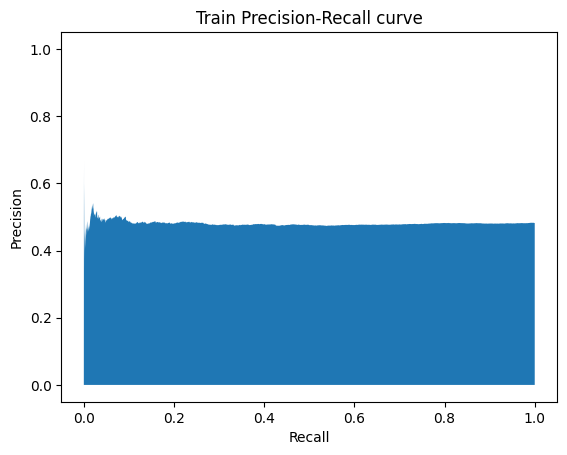

In [100]:
import matplotlib.pyplot as plt
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")